In [30]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -q /content/drive/MyDrive/datasets/Tomato.zip

replace Tomato/Tomato_Late_blight/03d8267a-c675-439f-9b98-a9c7653dd05e___GHLB2 Leaf 8558.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y


In [4]:
# initialize the data generator
datagen = ImageDataGenerator(validation_split=0.2)

# get training data
train_ds = datagen.flow_from_directory(
    '/content/Tomato',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training',  # set as training data
    seed=42
)

# get validation data
val_ds = datagen.flow_from_directory(
    '/content/Tomato',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # set as validation data
    seed=42,
    shuffle=False
)

Found 3601 images belonging to 3 classes.
Found 899 images belonging to 3 classes.


In [5]:
train_ds.class_indices

{'Tomato_Early_blight': 0, 'Tomato_Late_blight': 1, 'Tomato_healthy': 2}

In [6]:
es = EarlyStopping(patience = 5)

model1 = Sequential()

model1.add(layers.Input(shape=(256,256,3)))
model1.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# Dense Layers
model1.add(Dense(64, activation='relu'))

# Output
model1.add(Dense(3, activation='softmax'))

model1.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [7]:
model1.input_shape

(None, 256, 256, 3)

In [8]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0

In [11]:
h = model1.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 14s 125ms/step - loss: 0.0787 - accuracy: 0.9761 - val_loss: 0.4509 - val_accuracy: 0.8977
Epoch 2/20
113/113 [==============================] - 14s 126ms/step - loss: 0.0428 - accuracy: 0.9839 - val_loss: 0.3950 - val_accuracy: 0.8899
Epoch 3/20
113/113 [==============================] - 14s 124ms/step - loss: 0.0101 - accuracy: 0.9978 - val_loss: 0.3930 - val_accuracy: 0.9077
Epoch 4/20
113/113 [==============================] - 14s 122ms/step - loss: 0.0061 - accuracy: 0.9986 - val_loss: 0.4539 - val_accuracy: 0.9055
Epoch 5/20
113/113 [==============================] - 14s 122ms/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 0.5047 - val_accuracy: 0.9088
Epoch 6/20
113/113 [==============================] - 14s 126ms/step - loss: 0.0138 - accuracy: 0.9956 - val_loss: 0.5719 - val_accuracy: 0.8932
Epoch 7/20
113/113 [==============================] - 14s 123ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.4973 - val_ac

Prompted CHAT-GPT 4 to help grab the labels information from the validation dataset and get it into a numpy array, so that we can use that to make a confusion matrix.

In [12]:
y_true_classes = val_ds.labels

y_pred_classes = model1.predict(val_ds)

y_pred_classes = np.argmax(y_pred_classes, axis=1)

29/29 [==============================] - 3s 83ms/step


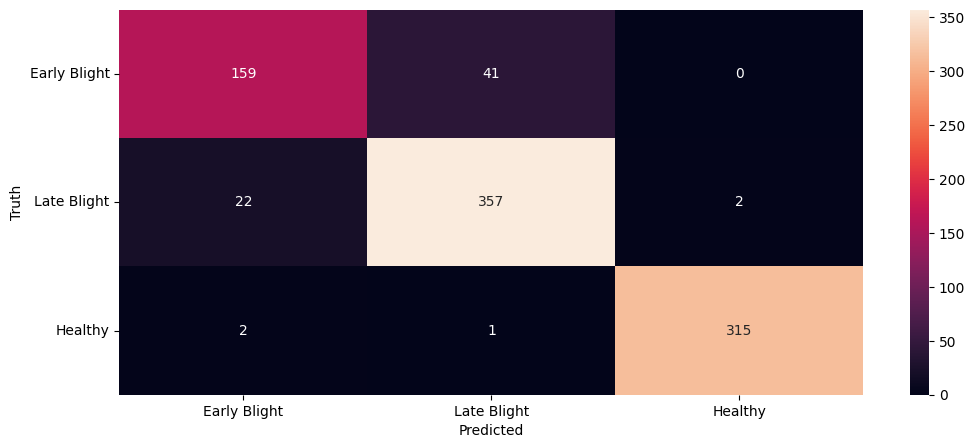

In [13]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d')

ax.set_yticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, va="center")
ax.set_xticklabels(['Early Blight', 'Late Blight', 'Healthy'], rotation=0, ha="center")

plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [14]:
report = classification_report(y_true_classes, y_pred_classes, target_names=val_ds.class_indices.keys())
print(report)

                     precision    recall  f1-score   support

Tomato_Early_blight       0.87      0.80      0.83       200
 Tomato_Late_blight       0.89      0.94      0.92       381
     Tomato_healthy       0.99      0.99      0.99       318

           accuracy                           0.92       899
          macro avg       0.92      0.91      0.91       899
       weighted avg       0.92      0.92      0.92       899



In [21]:
es = EarlyStopping(patience = 5)

model2 = Sequential()

model2.add(layers.Input(shape=(256,256,3)))
model2.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())

# Dense Layers
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))

# Output
model2.add(Dense(3, activation='softmax'))

model2.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
h = model2.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Gets overfit so let's try some regularization.

In [25]:
es = EarlyStopping(patience = 5)

model3 = Sequential()

model3.add(layers.Input(shape=(256,256,3)))
model3.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())

# Dense Layers
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.5))

# Output
model3.add(Dense(3, activation='softmax'))

model3.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
h = model3.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Still over fitting a lot, let's add another dropout layer.

In [27]:
es = EarlyStopping(patience = 5)

model4 = Sequential()

model4.add(layers.Input(shape=(256,256,3)))
model4.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())

# Dense Layers
model4.add(Dense(32, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.5))

# Output
model4.add(Dense(3, activation='softmax'))

model4.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)
h = model4.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Still over fitting by a lot. Before trying another dropout layer, let's add in a l2 regularization, and see what the results are.

In [34]:
es = EarlyStopping(patience = 5)

model5 = Sequential()

model5.add(layers.Input(shape=(256,256,3)))
model5.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model5.add(Conv2D(64, (3,3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Conv2D(64, (3,3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Flatten())

# Dense Layers
model5.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model5.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model5.add(Dropout(0.5))
model5.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model5.add(Dropout(0.5))

# Output
model5.add(Dense(3, activation='softmax'))

model5.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model5.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 16s 121ms/step - loss: 1.4675 - accuracy: 0.4157 - val_loss: 1.1653 - val_accuracy: 0.4238
Epoch 2/20
113/113 [==============================] - 14s 120ms/step - loss: 1.0452 - accuracy: 0.5429 - val_loss: 0.7973 - val_accuracy: 0.7386
Epoch 3/20
113/113 [==============================] - 13s 119ms/step - loss: 0.8106 - accuracy: 0.6934 - val_loss: 0.6570 - val_accuracy: 0.7230
Epoch 4/20
113/113 [==============================] - 13s 118ms/step - loss: 0.7180 - accuracy: 0.7262 - val_loss: 0.5805 - val_accuracy: 0.7508
Epoch 5/20
113/113 [==============================] - 14s 119ms/step - loss: 0.6353 - accuracy: 0.7551 - val_loss: 0.5832 - val_accuracy: 0.7831
Epoch 6/20
113/113 [==============================] - 14s 126ms/step - loss: 0.6275 - accuracy: 0.7506 - val_loss: 0.5222 - val_accuracy: 0.7798
Epoch 7/20
113/113 [==============================] - 14s 122ms/step - loss: 0.5631 - accuracy: 0.7742 - val_loss: 0.4960 - val_ac

The model just so happened to start with a really low score, so it was able to hit 20 epochs, but in attempts to reproduce, the model would stil overfit and early stop.

In [41]:
es = EarlyStopping(patience = 5)

model6 = Sequential()

model6.add(layers.Input(shape=(256,256,3)))
model6.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model6.add(Conv2D(64, (3,3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Conv2D(64, (3,3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Flatten())

# Dense Layers
model6.add(Dense(16, activation='relu', kernel_regularizer=l2(0.005)))
model6.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model6.add(Dropout(0.5))
model6.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))
model6.add(Dropout(0.5))
model6.add(Dense(32, activation='relu', kernel_regularizer=l2(0.005)))

# Output
model6.add(Dense(3, activation='softmax'))

model6.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model6.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 18s 122ms/step - loss: 1.5680 - accuracy: 0.4116 - val_loss: 1.3482 - val_accuracy: 0.4238
Epoch 2/20
113/113 [==============================] - 14s 121ms/step - loss: 1.2810 - accuracy: 0.4218 - val_loss: 1.2442 - val_accuracy: 0.4238
Epoch 3/20
113/113 [==============================] - 13s 119ms/step - loss: 1.1934 - accuracy: 0.4427 - val_loss: 1.1081 - val_accuracy: 0.5918
Epoch 4/20
113/113 [==============================] - 13s 119ms/step - loss: 1.1300 - accuracy: 0.5007 - val_loss: 1.1531 - val_accuracy: 0.4416
Epoch 5/20
113/113 [==============================] - 13s 118ms/step - loss: 1.0043 - accuracy: 0.6071 - val_loss: 0.8215 - val_accuracy: 0.7219
Epoch 6/20
113/113 [==============================] - 14s 121ms/step - loss: 0.7989 - accuracy: 0.7184 - val_loss: 0.6961 - val_accuracy: 0.7553
Epoch 7/20
113/113 [==============================] - 13s 118ms/step - loss: 0.6983 - accuracy: 0.7304 - val_loss: 0.6445 - val_ac

We've been tackling overfitting, but the accuracy on training is still worse than the validation of the original simple but overfit model. Adding more complexity hasn't really helped us that much. Let's start over, but now mess around with convolutions

In [42]:
es = EarlyStopping(patience = 5)

model7 = Sequential()

model7.add(layers.Input(shape=(256,256,3)))
model7.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model7.add(Conv2D(64, (4,4), activation='relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(Conv2D(64, (4,4), activation='relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(Flatten())

# Dense Layers
model7.add(Dense(64, activation='relu'))

# Output
model7.add(Dense(3, activation='softmax'))

model7.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model7.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 19s 143ms/step - loss: 1.5376 - accuracy: 0.4832 - val_loss: 0.8559 - val_accuracy: 0.5984
Epoch 2/20
113/113 [==============================] - 14s 121ms/step - loss: 0.7906 - accuracy: 0.6706 - val_loss: 0.6999 - val_accuracy: 0.7508
Epoch 3/20
113/113 [==============================] - 14s 121ms/step - loss: 0.5911 - accuracy: 0.7726 - val_loss: 0.6320 - val_accuracy: 0.7497
Epoch 4/20
113/113 [==============================] - 15s 129ms/step - loss: 0.4180 - accuracy: 0.8525 - val_loss: 0.4212 - val_accuracy: 0.8465
Epoch 5/20
113/113 [==============================] - 14s 124ms/step - loss: 0.2583 - accuracy: 0.9150 - val_loss: 0.4281 - val_accuracy: 0.8454
Epoch 6/20
113/113 [==============================] - 14s 124ms/step - loss: 0.4218 - accuracy: 0.8289 - val_loss: 0.7127 - val_accuracy: 0.7675
Epoch 7/20
113/113 [==============================] - 14s 121ms/step - loss: 0.2650 - accuracy: 0.9056 - val_loss: 0.5926 - val_ac

changing the convolution input matrix from 3 x 3 to 4 x 4 didn't have a great effect. Let's go back to 3 x 3 and instead see what happens if we add a conv layer and remove a conv layer.

In [43]:
es = EarlyStopping(patience = 5)

model8 = Sequential()

model8.add(layers.Input(shape=(256,256,3)))
model8.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model8.add(Conv2D(64, (3,3), activation='relu'))
model8.add(MaxPooling2D(pool_size=(2,2)))

model8.add(Conv2D(64, (3,3), activation='relu'))
model8.add(MaxPooling2D(pool_size=(2,2)))

model8.add(Conv2D(64, (3,3), activation='relu'))
model8.add(MaxPooling2D(pool_size=(2,2)))

model8.add(Flatten())

# Dense Layers
model8.add(Dense(64, activation='relu'))

# Output
model8.add(Dense(3, activation='softmax'))

model8.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model8.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 16s 124ms/step - loss: 0.5849 - accuracy: 0.7323 - val_loss: 0.3044 - val_accuracy: 0.8498
Epoch 2/20
113/113 [==============================] - 15s 129ms/step - loss: 0.2741 - accuracy: 0.8850 - val_loss: 0.1904 - val_accuracy: 0.9166
Epoch 3/20
113/113 [==============================] - 14s 125ms/step - loss: 0.2422 - accuracy: 0.9061 - val_loss: 0.1996 - val_accuracy: 0.9121
Epoch 4/20
113/113 [==============================] - 13s 119ms/step - loss: 0.1971 - accuracy: 0.9214 - val_loss: 0.3181 - val_accuracy: 0.8776
Epoch 5/20
113/113 [==============================] - 14s 123ms/step - loss: 0.1635 - accuracy: 0.9345 - val_loss: 0.1822 - val_accuracy: 0.9255
Epoch 6/20
113/113 [==============================] - 15s 130ms/step - loss: 0.0996 - accuracy: 0.9617 - val_loss: 0.1458 - val_accuracy: 0.9477
Epoch 7/20
113/113 [==============================] - 14s 123ms/step - loss: 0.0864 - accuracy: 0.9686 - val_loss: 0.1425 - val_ac

In [44]:
es = EarlyStopping(patience = 5)

model9 = Sequential()

model9.add(layers.Input(shape=(256,256,3)))
model9.add(layers.Rescaling(1./255))

# Convolutional and pooling layers
model9.add(Conv2D(64, (3,3), activation='relu'))
model9.add(MaxPooling2D(pool_size=(2,2)))

model9.add(Flatten())

# Dense Layers
model9.add(Dense(64, activation='relu'))

# Output
model9.add(Dense(3, activation='softmax'))

model9.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

h = model9.fit(train_ds,
               validation_data=val_ds,
               callbacks = [es],
               epochs=20)

Epoch 1/20
113/113 [==============================] - 14s 115ms/step - loss: 1.3916 - accuracy: 0.8137 - val_loss: 0.4978 - val_accuracy: 0.8098
Epoch 2/20
113/113 [==============================] - 13s 113ms/step - loss: 0.1594 - accuracy: 0.9428 - val_loss: 0.2270 - val_accuracy: 0.9088
Epoch 3/20
113/113 [==============================] - 13s 114ms/step - loss: 0.0475 - accuracy: 0.9883 - val_loss: 0.2839 - val_accuracy: 0.8910
Epoch 4/20
113/113 [==============================] - 14s 124ms/step - loss: 0.0217 - accuracy: 0.9964 - val_loss: 0.3466 - val_accuracy: 0.9032
Epoch 5/20
113/113 [==============================] - 13s 115ms/step - loss: 0.0088 - accuracy: 0.9981 - val_loss: 0.2739 - val_accuracy: 0.9066
Epoch 6/20
113/113 [==============================] - 13s 116ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.3132 - val_accuracy: 0.9177
Epoch 7/20
113/113 [==============================] - 13s 118ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3442 - val_ac